In [153]:
import pathlib
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, KBinsDiscretizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn import set_config
import joblib
import xgboost as xgb

# Enable pandas output globally
set_config(transform_output="pandas")

In [154]:
# Get path to train file
train_path = os.path.join(pathlib.Path.cwd().parent, "raw", "train.csv")
test_path = os.path.join(pathlib.Path.cwd().parent, "raw", "test.csv")
train_path

'c:\\Users\\bogus\\Desktop\\Projects\\Kaggle competitions\\Introverts\\raw\\train.csv'

In [155]:
train_df = pd.read_csv(train_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)
train_df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [156]:
numerical_vars = train_df.select_dtypes(include='number').columns.tolist()
categorical_vars = train_df.drop(labels="Personality", axis=1).select_dtypes(include='object').columns.tolist()
y_var = "Personality"
numerical_vars, categorical_vars, y_var

(['Time_spent_Alone',
  'Social_event_attendance',
  'Going_outside',
  'Friends_circle_size',
  'Post_frequency'],
 ['Stage_fear', 'Drained_after_socializing'],
 'Personality')

In [157]:
numerical_pipeline = Pipeline(
    [
        # ("missing_ind", MissingIndicator(sparse=False)),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        # ("minmax", KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="uniform")),
        # ("onehot", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]
)

categorical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
        ("onehot", OneHotEncoder(sparse_output=False))
    ]
)

preprocessing_pipeline = Pipeline(
    [
        ("column_transformer", ColumnTransformer(
            [
                ("numerical", numerical_pipeline, numerical_vars),
                ("categorical", categorical_pipeline, categorical_vars),
                ("missing_indicator", MissingIndicator(), numerical_vars)
            ]
        ))
    ]
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing_pipeline),
        ("interactions", ColumnTransformer(
            [
                ('drop_cols', 'drop', [
                    "categorical__Stage_fear_Missing",
                    "missing_indicator__missingindicator_Friends_circle_size",
                    "categorical__Drained_after_socializing_Missing"
                    # "numerical__Going_outside_1.0",
                    # "categorical__Drained_after_socializing_Yes",
                    # "categorical__Stage_fear_Yes",
                    # "numerical__Friends_circle_size_1.0"
                ])
            ],
            remainder="passthrough",
            verbose_feature_names_out=False
        )
        )
        # ("interactions", PolynomialFeatures(degree=2, interaction_only=True))
    ]
)

In [158]:
pipeline.fit(train_df)

C:\Users\bogus\AppData\Roaming\Python\Python313\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                   ['Time_spent_Alone',
                                                                    'Social_event_attendance',
                                                                    'Going_outside',
                                                                    'Friends_circle_size',
                                                                    'Post_frequency']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_...
                                                                    'Social_event_attendance',
                                                                    'Going_outside',
                                                                    'Friends_circle_size',
                                                                    'Post_frequency'])]))])),
                ('interactions',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_cols', 'drop',
                                                  ['categorical__Stage_fear_Missing',
                                                   'missing_indicator__missingindicator_Friends_circle_size',
                                                   'categorical__Drained_after_socializing_Missing'])],
                                   verbose_feature_names_out=False))])

In [159]:
cleaned_df = pipeline.transform(train_df)
cleaned_df.head()

,numerical__Time_spent_Alone,numerical__Social_event_attendance,numerical__Going_outside,numerical__Friends_circle_size,numerical__Post_frequency,categorical__Stage_fear_No,categorical__Stage_fear_Yes,categorical__Drained_after_socializing_No,categorical__Drained_after_socializing_Yes,missing_indicator__missingindicator_Time_spent_Alone,missing_indicator__missingindicator_Social_event_attendance,missing_indicator__missingindicator_Going_outside,missing_indicator__missingindicator_Post_frequency
id,,,,,,,,,,,,,
0,0.0,6.0,4.0,15.0,5.0,1.0,0.0,1.0,0.0,False,False,False,False
1,1.0,7.0,3.0,10.0,8.0,1.0,0.0,1.0,0.0,False,False,False,False
2,6.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,False,False,False,False
3,3.0,7.0,3.0,11.0,5.0,1.0,0.0,1.0,0.0,False,False,False,False
4,1.0,4.0,4.0,13.0,3.0,1.0,0.0,1.0,0.0,False,False,False,True


In [160]:
dtrain = xgb.DMatrix(cleaned_df, train_df[y_var].map({"Extrovert": 1, "Introvert": 0}))

In [161]:
param = {"max_depth": 30, "eta": 0.3, "objective": "binary:logistic", "num_boost_round": 20, "eval_metric": "error", "early_stopping_rounds": 10}
watchlist = [(dtrain, "train")]
# bst = xgb.train(param, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)

In [162]:
cv_results = xgb.cv(
    params=param,
    dtrain=dtrain,
    num_boost_round=param["num_boost_round"],
    nfold=5,                         # 5-fold CV
    stratified=True,                # Important for classification
    early_stopping_rounds=param["early_stopping_rounds"],
    verbose_eval=True,
    seed=42
)

C:\Users\bogus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:209: UserWarning: [21:31:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
C:\Users\bogus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:215: UserWarning: [21:31:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


[0]	train-error:0.03146+0.00053	test-error:0.03169+0.00185
[1]	train-error:0.03116+0.00076	test-error:0.03180+0.00217
[2]	train-error:0.03034+0.00052	test-error:0.03185+0.00208
[3]	train-error:0.02987+0.00061	test-error:0.03180+0.00206
[4]	train-error:0.02970+0.00055	test-error:0.03158+0.00182
[5]	train-error:0.02938+0.00044	test-error:0.03158+0.00155
[6]	train-error:0.02915+0.00057	test-error:0.03142+0.00156
[7]	train-error:0.02888+0.00057	test-error:0.03153+0.00158
[8]	train-error:0.02873+0.00058	test-error:0.03142+0.00152
[9]	train-error:0.02861+0.00059	test-error:0.03136+0.00154
[10]	train-error:0.02844+0.00059	test-error:0.03131+0.00171
[11]	train-error:0.02821+0.00049	test-error:0.03120+0.00171
[12]	train-error:0.02790+0.00059	test-error:0.03153+0.00170
[13]	train-error:0.02764+0.00057	test-error:0.03153+0.00161
[14]	train-error:0.02732+0.00060	test-error:0.03120+0.00166
[15]	train-error:0.02703+0.00056	test-error:0.03136+0.00182
[16]	train-error:0.02661+0.00063	test-error:0.0314

In [163]:
bst = xgb.train(param, dtrain, param["num_boost_round"], evals=watchlist, early_stopping_rounds=param["early_stopping_rounds"])
preds = bst.predict(dtrain)
print(sum((preds > 0.5) == train_df[y_var].map({"Extrovert": 1, "Introvert": 0})) / len(train_df))

[0]	train-error:0.03147


[1]	train-error:0.03115
[2]	train-error:0.03029
[3]	train-error:0.02980


C:\Users\bogus\AppData\Roaming\Python\Python313\site-packages\xgboost\callback.py:386: UserWarning: [21:31:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[4]	train-error:0.02942
[5]	train-error:0.02937
[6]	train-error:0.02921
[7]	train-error:0.02899
[8]	train-error:0.02888
[9]	train-error:0.02861
[10]	train-error:0.02850
[11]	train-error:0.02823
[12]	train-error:0.02802
[13]	train-error:0.02764
[14]	train-error:0.02748
[15]	train-error:0.02715
[16]	train-error:0.02683
[17]	train-error:0.02645
[18]	train-error:0.02597
[19]	train-error:0.02548
0.9745195422155042


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

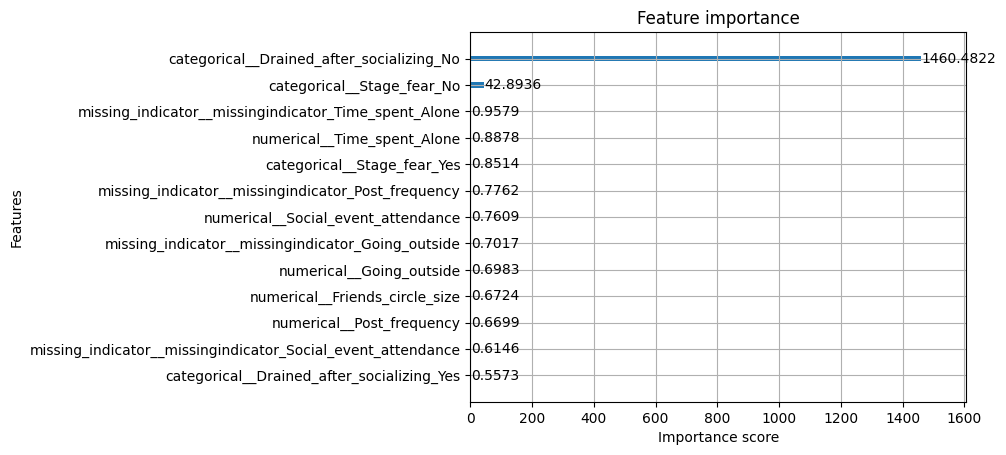

In [164]:
xgb.plot_importance(bst, importance_type='gain', max_num_features =100, values_format ="{v:.4f}")


In [165]:
test_transformed = pipeline.transform(test_df)
dtest = xgb.DMatrix(test_transformed)
y_pred_probs = bst.predict(dtest)
# y_pred_probs
test_predict = pd.DataFrame({"Prediction": y_pred_probs > 0.5}).astype(int)# .map({0: "Introvert", 1: "Extrovert"})
test_predict["Prediction"] = test_predict["Prediction"].map({0: "Introvert", 1: "Extrovert"})
test_predict

,Prediction
0,Extrovert
1,Introvert
2,Extrovert
3,Extrovert
4,Introvert
...,...
6170,Extrovert
6171,Introvert
6172,Extrovert
6173,Extrovert


In [166]:
write_df = pd.DataFrame(
    {
        "id": test_df.index,
        y_var: test_predict["Prediction"]
    }
)

In [167]:
write_df.to_csv("submission.csv", index=False)